In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading loan data.

In [2]:
loan_data = pd.read_csv('loan.csv',low_memory=False)

### Data Cleaning
1. Converted interest rate column to float.
2. Extracted year from the loan issue date 
3. Droped columns in which half of the data was empty.

In [3]:
# Dropping columns in which half of the values are missing.
loan_data = loan_data.dropna(thresh=50,axis=1)
loan_data['issued_year'] = loan_data.issue_d.str.extract('(\d+)').astype(float)
loan_data['term'] = loan_data.term.str.strip('months').astype(int)
loan_data.emp_length = loan_data.emp_length.str.extract('(\d+)').astype(float)
loan_data.int_rate = loan_data.int_rate.str.strip('%').astype(float)


As we are analysing the data to predict who could be a defaulter. I have filtered the data set to consider only 
fully paid and Charged off customers.

In [4]:
loan_data = loan_data[loan_data.loan_status.isin(['Fully Paid', 'Charged Off'])]
loan_data.loan_status.value_counts()

Fully Paid     32950
Charged Off     5627
Name: loan_status, dtype: int64

Droped columns as there is no use of id and meber_id columns and few others.

In [5]:
# Removed unnesesory columns 
loan_data = loan_data.drop(columns = ['id','member_id','tax_liens','pub_rec_bankruptcies',
                                      'policy_code','collections_12_mths_ex_med','acc_now_delinq',
                                      'chargeoff_within_12_mths','delinq_amnt','out_prncp','out_prncp_inv'], axis=1)



#### Graph showing the percentage of users from fully paid and charged Off.

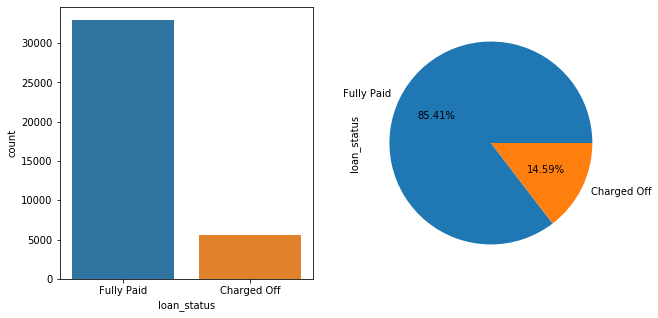

In [6]:
# Number of users who had paid fully, Charged Off and Current.
fig, axs = plt.subplots(1,2,figsize=(10,5))
sns.countplot(x='loan_status',data=loan_data,ax=axs[0])
loan_data['loan_status'].value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')

### Users varification report.

Text(0, 0.5, '  Varification Status')

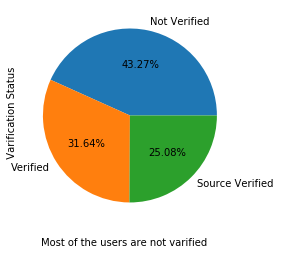

In [7]:
plt.figure().text(.5, .05, "Most of the users are not varified", ha='center')
loan_data.verification_status.value_counts().plot(x=None,y=None, kind='pie', autopct='%1.2f%%')
plt.ylabel('  Varification Status')

In [8]:
# Count of charged off users from not verified source
loan_data.pivot_table(index='loan_status', columns='verification_status',values='grade', aggfunc='count')

verification_status,Not Verified,Source Verified,Verified
loan_status,,,
Charged Off,2142,1434,2051
Fully Paid,14552,8243,10155


From the below table, it looks a strong correlation between the dti funded amount and loan amount and 
a negetive correlation between dti and annual income.

In [9]:
charged_off_data = loan_data[loan_data.loan_status == 'Charged Off']
fully_paid_data = loan_data[loan_data.loan_status == 'Fully Paid']

loan_data[['dti','funded_amnt','loan_amnt','funded_amnt_inv','annual_inc']].corr().style.background_gradient(cmap='coolwarm', axis=None)

,dti,funded_amnt,loan_amnt,funded_amnt_inv,annual_inc
dti,1,0.0621941,0.0624358,0.070663,-0.12153
funded_amnt,0.0621941,1,0.98179,0.956172,0.264798
loan_amnt,0.0624358,0.98179,1,0.937922,0.268999
funded_amnt_inv,0.070663,0.956172,0.937922,1,0.251981
annual_inc,-0.12153,0.264798,0.268999,0.251981,1


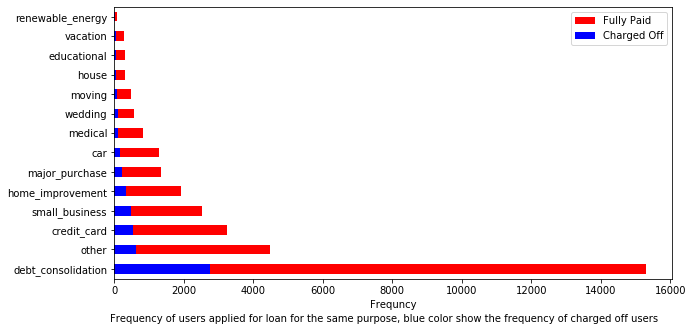

In [10]:
# Number of customers applied for the same purpose.
plt.figure(figsize=(10,5)).text(
    .5, 
    .005, 
    'Frequency of users applied for loan for the same purpose, blue color show the frequency of charged off users', 
    ha='center'
)
loan_data[loan_data.loan_status=='Fully Paid'].purpose.value_counts().plot.barh(color=['red'],  label='Fully Paid')
loan_data[loan_data.loan_status=='Charged Off'].purpose.value_counts().plot.barh(color=['blue'], label="Charged Off")
plt.xlabel('Frequncy')
plt.legend()


Added a new columns named "Annual Income Range."

In [11]:

# Annual income range filter 
df_inc_range = pd.DataFrame(
    [-10000,20000,40000,60000,80000,100000,120000,140000,160000,180000,200000,250000,500000,1000000,5000000,6000000]
)

df_inc_range.columns = ['range']
df_inc_range.head()
new_inc_range_category = pd.cut(loan_data.annual_inc,df_inc_range.range,duplicates='drop').to_frame()
new_inc_range_category.columns = ['annual_inc_range']
loan_data =  pd.concat([loan_data,new_inc_range_category], axis=1)



Income range in which most of the charged off users are lying.

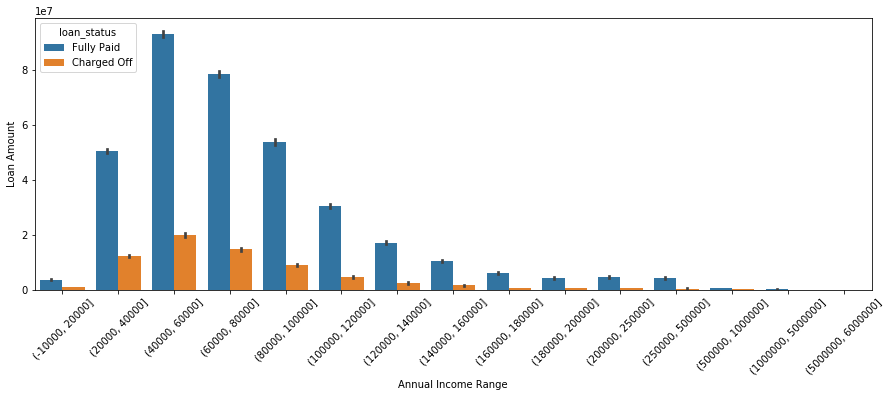

In [12]:
fig, ax =plt.subplots(1,1,figsize=(15,5))
s0 = sns.barplot(
    x="annual_inc_range", 
    y="loan_amnt", 
    hue="loan_status", 
    data=loan_data[["annual_inc_range", "loan_amnt", "loan_status"]], 
    estimator=sum
)
s0.set(xlabel='Annual Income Range',ylabel='Loan Amount')
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)
plt.show()

Fequency of Charged Off users belongs to different grades.

In [13]:
pivot_table_grade  = loan_data[['loan_status','grade','sub_grade']].pivot_table(
    index = 'loan_status', 
    values =['sub_grade'],
    columns = ['grade'], 
    aggfunc='count')
pivot_table_grade.sort_values('Charged Off', axis=1, ascending=False)

sub_grade                                  
grade               B     C     D     E     A    F    G
loan_status                                            
Charged Off      1425  1347  1118   715   602  319  101
Fully Paid      10250  6487  3967  1948  9443  657  198

1. Most of the loan amount issued to the users belogs to G sub grade 2
2. 10 years employment length users consume most the loan amount. 

Clearly visuble from the below graphs.

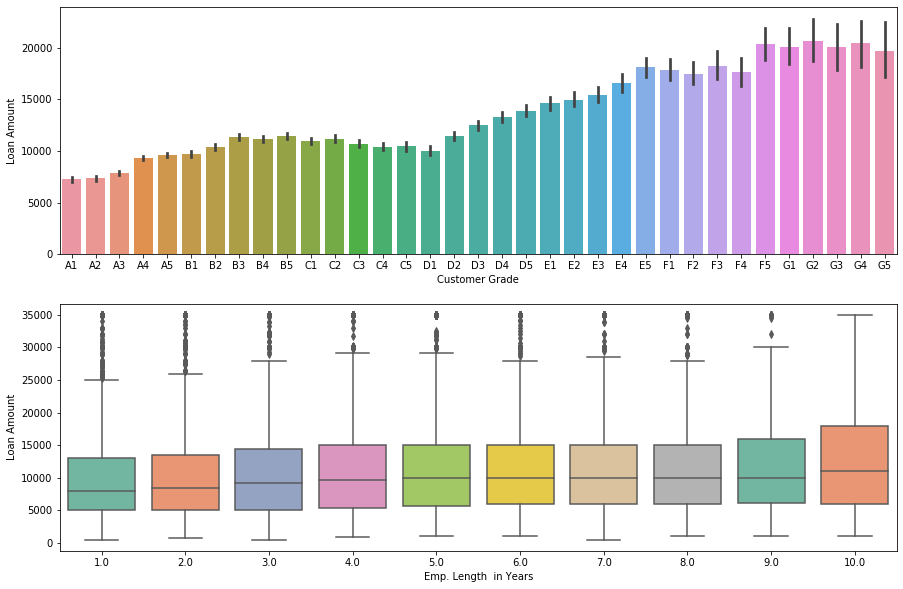

In [14]:
fig, ax = plt.subplots(2,1, figsize=(15,10))

# To draw a graph between loan amount and sub grade
s3 = sns.barplot(
    x="sub_grade", 
    y="loan_amnt", 
    data=loan_data, 
    ax=ax[0], 
    order=loan_data.sub_grade.sort_values().unique()
)

# To draw graph between loan amount and employment length in years
s3.set(xlabel='Customer Grade',ylabel='Loan Amount')
s1 = sns.boxplot(
    x="emp_length", 
    y="loan_amnt", 
    data=loan_data, 
    palette="Set2",ax=ax[1]
)
s1.set(xlabel='Emp. Length  in Years',ylabel='Loan Amount')
plt.show()

By the time a huge incline in the issued loan can be seen from below plot.

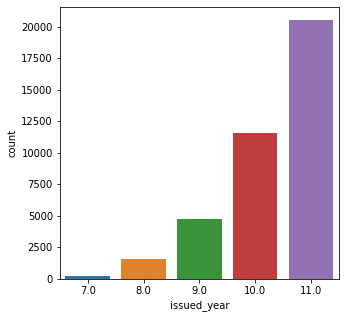

In [15]:
plt.figure(figsize=(5,5))
sns.countplot(x='issued_year',data=loan_data)

#### Added a new column named interest range filter.

In [16]:

# Interest range filter 
df_int_range = pd.DataFrame(
    np.arange(int(loan_data.int_rate.min()), int(loan_data.int_rate.max()), 2)
)

df_int_range.columns = ['range']

new_int_range_category = pd.cut(loan_data.int_rate,df_int_range.range,duplicates='drop').to_frame()
new_int_range_category.columns = ['int_rate_range']
loan_data =  pd.concat([loan_data,new_int_range_category], axis=1)

Graph to disply number of users lying in interest rate range

In [ ]:
fig, ax =plt.subplots(1,1,figsize=(10,5))
s5 = sns.barplot(x="int_rate_range", y="loan_amnt", hue="loan_status", data=loan_data[["int_rate_range", "loan_amnt", "loan_status"]], estimator=sum)
s5.set(xlabel='Interest Rate Range',ylabel='Loan Amount')
s5.set_xticklabels(s5.get_xticklabels(),rotation=45)
plt.show()

#### Number of defaulters in each state

In [18]:
table = loan_data.pivot_table(index='loan_status', columns='addr_state', values='grade', aggfunc='count')

table.iloc[:, :12].sort_values('Charged Off', axis=1, ascending=False)

addr_state,CA,FL,GA,AZ,CO,CT,AL,HI,AR,AK,DC,DE
loan_status,,,,,,,,,,,,
Charged Off,1125.0,504.0,215.0,123.0,98.0,94.0,54.0,28.0,27.0,15.0,15.0,12.0
Fully Paid,5824.0,2277.0,1144.0,726.0,668.0,632.0,381.0,138.0,208.0,63.0,196.0,101.0


##### The average number of months for in which the Charged Off user lying.

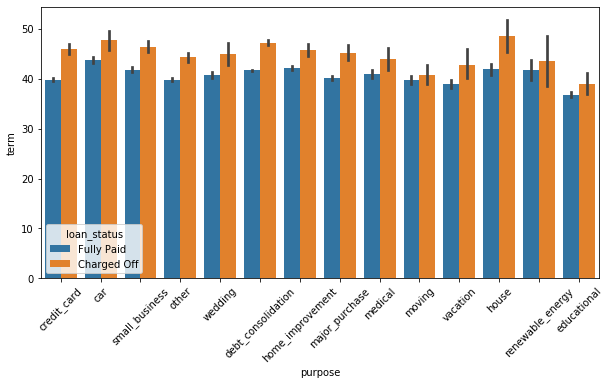

In [19]:
fig, ax =plt.subplots(1,1,figsize=(10,5))
s5 = sns.barplot(
    x="purpose", 
    y="term", 
    hue='loan_status', 
    data=loan_data[["term", "purpose", "loan_status"]], 
    estimator=np.mean
)
#s5.set(xlabel='Interest Rate Range',ylabel='Loan Amount')
s5.set_xticklabels(s5.get_xticklabels(),rotation=45)
plt.show()